In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('mode.chained_assignment', None)


# gateway.logs  parse 2022-06-14 22:12:19.000   - 28.06.2022

In [2]:
gateway = pd.read_csv("gateway.log",header=None, names=list('abcdefghijklmnoprstuwz'), low_memory=False )
gateway1 = pd.read_csv("gateway.log.1",header=None, names=list('abcdefghijklmnoprstuwz'), low_memory=False )
gateway2 = pd.read_csv("gateway.log.2",header=None, names=list('abcdefghijklmnoprstuwz'), low_memory=False )
gateway3 = pd.read_csv("gateway.log.3",header=None, names=list('abcdefghijklmnoprstuwz'), low_memory=False )
gateway = pd.concat([gateway1, gateway], ignore_index=True, sort=False)
gateway = pd.concat([gateway2, gateway], ignore_index=True, sort=False)
gateway = pd.concat([gateway3, gateway], ignore_index=True, sort=False)

gateway = gateway["a"].str.split(' ', expand=True)
gateway.columns = ["date", "time", "2", "3",  "4",  "5", "stored" , "7" , "8" , "mosaic", "10", "11" ,"12", "13", "14", "15"]
gateway['datetime'] = gateway["date"] + " " + gateway['time']
gateways = gateway
#  date since first test start of 15 mosaics -> 2022-06-14 22:12:19.000

gateway = gateway[(gateway['date'] > '2022-06-14') & (gateway['date'] < '2022-07-14')]

gateway = gateway[(gateway['datetime'] > '2022-06-14 22:12:19.000')]
gateway['datetime'] = pd.to_datetime(gateway['datetime'])


# errors

In [3]:
errors = gateway[(gateway['2'] == 'ERROR')]
errors_count = errors['3'].value_counts()
errors_count

run_gateway    80369
base_events      145
Name: 3, dtype: int64

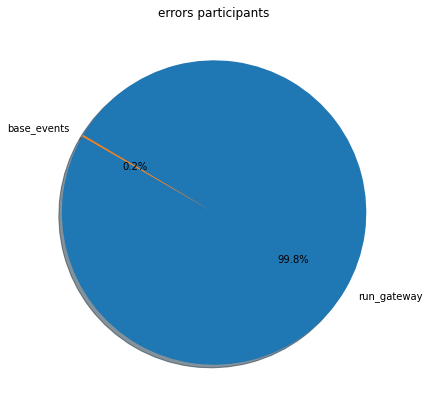

In [4]:
plt.figure(figsize=(14,7))
plt.title ('errors participants')
plt.pie(errors_count, labels = errors_count.index, autopct='%1.1f%%',startangle=150,shadow=True);

# Errory - wnioski 

są dwa rodzaje errorów do których przypisana jest data:
- 0,2 % base_evenets - 145 razy 
- 98, 8 % gateway errors - 80368 razy

w logach pojawiały się również linie mówiące o connection error, 
nie mniej nie były to wpisy przypisane do daty, przyjmowały formę uciętej linii

1. base_events errors - niosły  info : Task	exception was never retrieved, 
    występowanie ich w czasie zostało zobrazowane na grafie
    

2. gateway errory - niosły info nadrzędnmie: Error during processing from Socket:
    najdłuższy czas działania pomiędzy errorami, zobrazowany został na grafie, 
    można wyciągnąć wniosek, że połączenie z socketem dawało większość błedów

### 1. errors - base_events

In [6]:
errors_events = errors[(errors['3'] == 'base_events')]
errors_events['time_diff'] = errors_events['datetime'].diff()
errors_events = errors_events[['datetime', 'time_diff', 'stored', '7', '8', 'mosaic', '10' ]]
errors_events = errors_events.iloc[1:]

errors_events.head(3)

,datetime,time_diff,stored,7,8,mosaic,10
2355134,2022-06-18 19:26:00.808,3 days 06:03:01.053000,Task,exception,was,never,retrieved
2366416,2022-06-18 20:45:29.822,0 days 01:19:29.014000,Task,exception,was,never,retrieved
2377950,2022-06-18 22:14:48.248,0 days 01:29:18.426000,Task,exception,was,never,retrieved


In [7]:
errors_events.describe()

,time_diff
count,144
mean,0 days 02:09:49.928256944
std,0 days 14:15:09.725882200
min,0 days 00:00:00.002000
25%,0 days 00:00:00.003000
50%,0 days 00:00:00.004000
75%,0 days 00:00:00.029500
max,5 days 22:33:57.451000


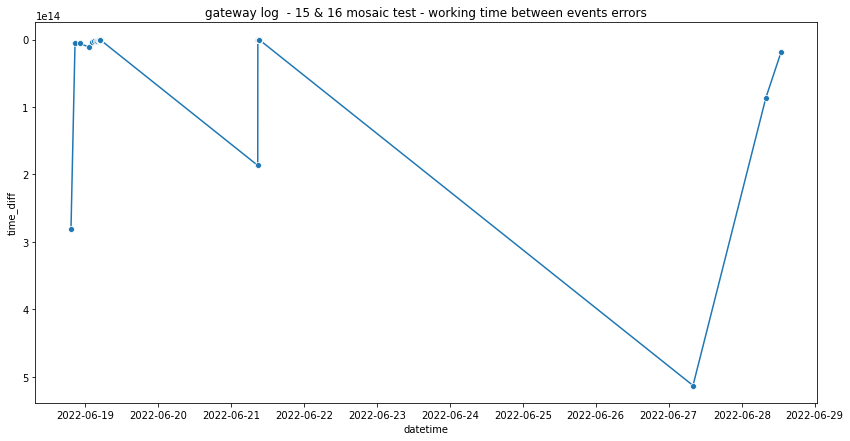

In [8]:
errors_events2 = errors_events.sort_values(by =['time_diff', 'datetime'] )
plt.figure(figsize=(14,7))
plt.title('gateway log  - 15 & 16 mosaic test - working time between events errors')

sns.lineplot(data = errors_events, x  = 'datetime', y = 'time_diff', marker='o');

### 2. errors - run gateway

In [9]:
errors_gateway = errors[(errors['3'] == 'run_gateway')]
errors_gateway['time_diff'] = errors_gateway['datetime'].diff()
errors_gateway = errors_gateway[['datetime', 'time_diff', 'stored', '7', '8', '10', '12' ]]
errors_gateway = errors_gateway.iloc[1:]

errors_gateway.head(3)

,datetime,time_diff,stored,7,8,10,12
1404114,2022-06-15 00:00:04.732,0 days 00:00:03.508000,Error,during,processing,from,Socket:
1404124,2022-06-15 00:00:05.233,0 days 00:00:00.501000,Error,during,processing,from,Socket:
1404134,2022-06-15 00:00:05.734,0 days 00:00:00.501000,Error,during,processing,from,Socket:


In [10]:
errors_gateway.time_diff.value_counts().head(10)

0 days 00:00:01.002000    5658
0 days 00:00:00.501000    4465
0 days 00:00:02.004000    3013
0 days 00:00:03.005000    2670
0 days 00:00:02.003000    2262
0 days 00:00:05.002000    1859
0 days 00:00:03.006000    1781
0 days 00:00:04.007000    1668
0 days 00:00:01.003000    1433
0 days 00:00:01.001000    1114
Name: time_diff, dtype: int64

In [11]:
errors_gateway.describe()

,time_diff
count,80368
mean,0 days 00:00:15.042760165
std,0 days 00:01:06.807714763
min,0 days 00:00:00.001000
25%,0 days 00:00:01.603000
50%,0 days 00:00:04.007000
75%,0 days 00:00:08.808000
max,0 days 00:52:07.643000


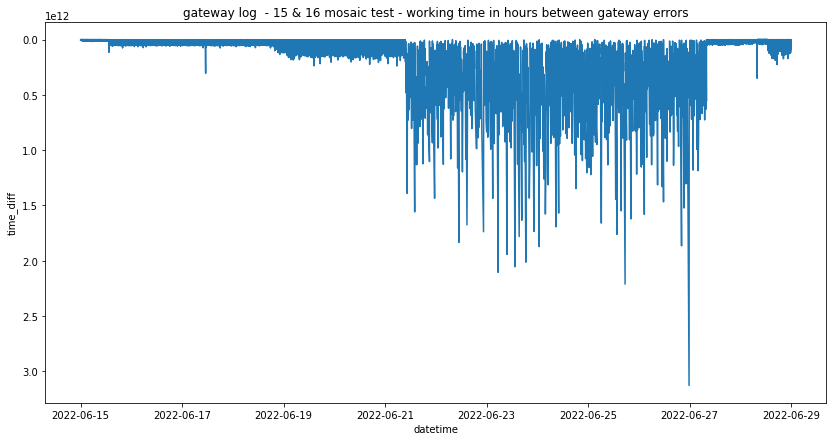

In [12]:
plt.figure(figsize=(14,7))
plt.title('gateway log  - 15 & 16 mosaic test - working time in hours between gateway errors')
sns.lineplot(data = errors_gateway, x  = 'datetime', y = 'time_diff');

# wnioski gateway starts

czas działania pomiędzy restartami został zobrazowany na grafach,

najdłuższy czas pomiędzy startami gateway wyniósł ok 142 h -  5 days 22:33:57.968000, 

co może definiować dobrze dobraną konfigurację 


### 3. time between gateway starts

In [13]:
start = gateways[(gateways['stored'] == 'Starting')]
start.at[1299858,'datetime'] = '2022-06-14 20:24:58.436'
start = start[['datetime']]
start['datetime'] = pd.to_datetime(start['datetime'])
start = start[(start['datetime'] > '2022-06-14 22:12:19.000')]
start['time_diff'] = start['datetime'].diff()
start['time_diff_hours'] = start.apply(lambda row: row['time_diff'].total_seconds() / 3600, axis = 1)
start = start.iloc[1:]

start

,datetime,time_diff,time_diff_hours
1355341,2022-06-14 22:23:59.954,0 days 00:11:40.896000,0.194693
1389968,2022-06-14 23:33:46.604,0 days 01:09:46.650000,1.162958
1638369,2022-06-15 13:21:55.670,0 days 13:48:09.066000,13.802518
2355033,2022-06-18 19:24:59.690,3 days 06:03:04.020000,78.051117
2366318,2022-06-18 20:44:28.415,0 days 01:19:28.725000,1.324646
2369882,2022-06-18 21:11:10.517,0 days 00:26:42.102000,0.445028
2377857,2022-06-18 22:13:46.708,0 days 01:02:36.191000,1.043386
2400268,2022-06-19 01:21:34.104,0 days 03:07:47.396000,3.129832
2407343,2022-06-19 02:23:38.067,0 days 01:02:03.963000,1.034434
2411360,2022-06-19 02:57:14.146,0 days 00:33:36.079000,0.560022


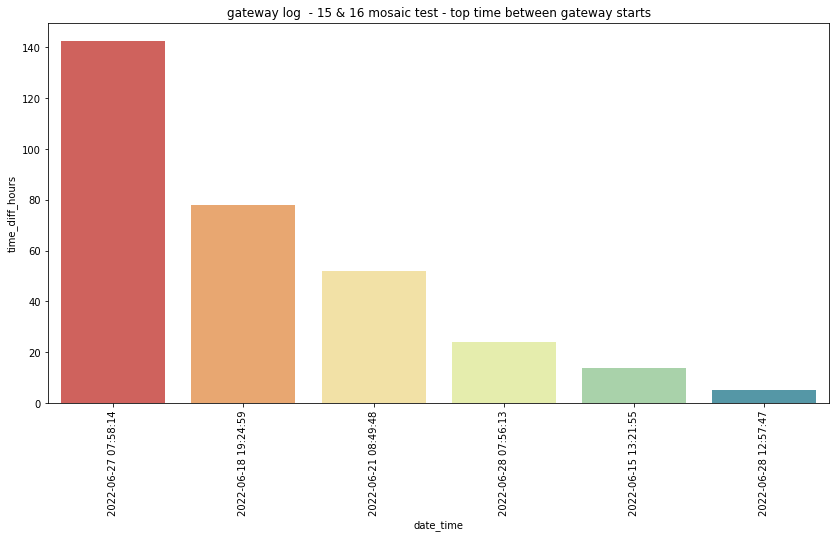

In [14]:
start_sort = start.sort_values(by= 'time_diff_hours', ascending = False).head(6)
start_sort["datetime"] = start_sort["datetime"].astype(str)
start_sort[['date_time', 'drop']] = start_sort['datetime'].str.split('.', n=1, expand=True)

plt.figure(figsize=(14,7))
sns.barplot(data = start_sort, x='date_time', y= "time_diff_hours", palette='Spectral')
plt.xticks(rotation=90)
plt.title('gateway log  - 15 & 16 mosaic test - top time between gateway starts');


   # wnioski stored images

W logu pojawiały się linie mówiące o przesyłaniu obrazu, przesyłane były dwa typy obrazów:

    image       552436 razy 
    RGBImage       193 razy 
    
Na grafach zostały zobrazowane, ilości wysłanych obrazów dla każdego typu obrazu w odniesieniu do numeru moziki.

RGBImage       193 razy :

127.    20
128.    19
104.    19
107.    19
129.    18
122.    18
106.    17
126.    17
123.    17
120.    16
121.    13
    
    
image  552436 razy:   

121.    36700 
126.    36552
107.    36510
104.    36509
127.    36501
131.    36492
130.    36464
106.    36436
128.    36310
132.    36154
122.    36128
123.    36065
129.    36027
124.    35985
120.    34468
125.     7941
133.     1194   
    
Analizując czasy przesyłu zdjęć dla obu typów :

RGBImage: potrzebował do 12 sekund czasu by przesłać zdjęcie, optymalnym czasem przesyłu było do sec    


image: wykazywał do 1 min 30 secund pomiędzy przesyłem dla danej mozaiki w przypadku analizowania powrotu mozaiki, 
optymalnym czasem było przesłane zdjęcie do 5 secund


Czasy pomiędzy przesyłami wraz z odniesieniem statystycznym dla każdej mozaiki,zostały zobrazowane w describach oraz na grafach 
    

#  time between stored images

In [15]:
stored = gateway[(gateway['stored'] == 'Stored') & (gateway['mosaic'] != 'from')  ]
stored = stored[['datetime', "7", 'mosaic']]

stored_count = stored["7"].value_counts()
stored_count

image       552436
RGBImage       193
Name: 7, dtype: int64

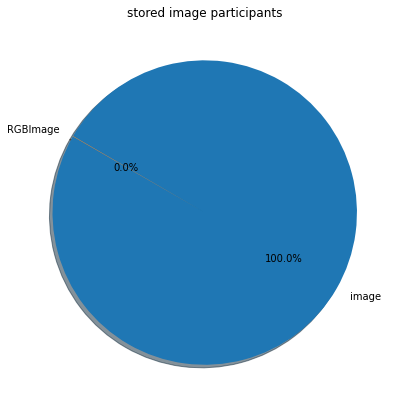

In [16]:
plt.figure(figsize=(14,7))
plt.title ('stored image participants')
plt.pie(stored_count, labels = stored_count.index, autopct='%1.1f%%',startangle=150,shadow=True);

### 4. time between RGBImage stored

In [17]:
stored_RGBImage = stored[(stored['7'] == 'RGBImage')]
stored_RGBImage.head(3) 

,datetime,7,mosaic
1638373,2022-06-15 13:21:59.563,RGBImage,128.
1638376,2022-06-15 13:22:01.406,RGBImage,104.
1638379,2022-06-15 13:22:02.608,RGBImage,106.


In [18]:
stored_RGBImage.mosaic.value_counts()

127.    20
128.    19
104.    19
107.    19
129.    18
122.    18
106.    17
126.    17
123.    17
120.    16
121.    13
Name: mosaic, dtype: int64

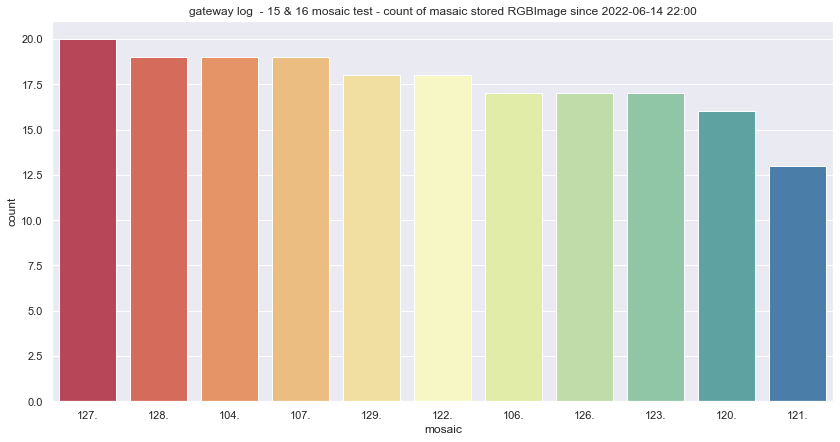

In [19]:
sns.set(style="darkgrid")
plt.figure(figsize=(14,7))
plt.title ('gateway log  - 15 & 16 mosaic test - count of masaic stored RGBImage since 2022-06-14 22:00')

sns.countplot(x='mosaic', data=stored_RGBImage , palette='Spectral', order = stored_RGBImage.mosaic.value_counts().index);

In [20]:
stored_RGBImage['time_diff'] = stored_RGBImage['datetime'].diff()
stored_RGBImage.describe()

,time_diff
count,192
mean,0 days 01:37:22.501869791
std,0 days 12:22:04.389903882
min,0 days 00:00:00.021000
25%,0 days 00:00:01.200000
50%,0 days 00:00:02.019000
75%,0 days 00:00:03.823750
max,5 days 22:33:50.613000


In [21]:
stored_RGBImage = stored_RGBImage[(stored_RGBImage['time_diff'] < '0 days 00:03:00.000000')]

In [22]:
stored_RGBImage.describe()

,time_diff
count,173
mean,0 days 00:00:02.343248554
std,0 days 00:00:01.869262885
min,0 days 00:00:00.021000
25%,0 days 00:00:01.149000
50%,0 days 00:00:01.830000
75%,0 days 00:00:02.708000
max,0 days 00:00:12.047000


In [23]:
stored_RGBImage.groupby(['mosaic'])['time_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
mosaic,,,,,,,,
104.,18,0 days 00:00:02.796000,0 days 00:00:01.256483468,0 days 00:00:00.839000,0 days 00:00:01.891000,0 days 00:00:02.833500,0 days 00:00:03.879500,0 days 00:00:04.717000
106.,17,0 days 00:00:01.730235294,0 days 00:00:00.607408895,0 days 00:00:00.828000,0 days 00:00:01.202000,0 days 00:00:01.782000,0 days 00:00:02.275000,0 days 00:00:02.681000
107.,19,0 days 00:00:01.939894736,0 days 00:00:01.842342165,0 days 00:00:00.093000,0 days 00:00:00.852000,0 days 00:00:01.546000,0 days 00:00:02.157500,0 days 00:00:07.976000
120.,16,0 days 00:00:01.827812500,0 days 00:00:01.195189369,0 days 00:00:00.541000,0 days 00:00:01.013500,0 days 00:00:01.705500,0 days 00:00:02.062250,0 days 00:00:05.043000
121.,13,0 days 00:00:02.163923076,0 days 00:00:01.847660974,0 days 00:00:00.021000,0 days 00:00:00.820000,0 days 00:00:02.077000,0 days 00:00:02.218000,0 days 00:00:07.468000
122.,18,0 days 00:00:01.703833333,0 days 00:00:01.513896579,0 days 00:00:00.527000,0 days 00:00:00.878500,0 days 00:00:01.295000,0 days 00:00:02.018500,0 days 00:00:07.171000
123.,17,0 days 00:00:01.458294117,0 days 00:00:00.942591889,0 days 00:00:00.564000,0 days 00:00:00.753000,0 days 00:00:01.231000,0 days 00:00:01.803000,0 days 00:00:04.189000
126.,17,0 days 00:00:04.545823529,0 days 00:00:01.969792255,0 days 00:00:01.640000,0 days 00:00:02.951000,0 days 00:00:04.454000,0 days 00:00:06.352000,0 days 00:00:07.515000
127.,20,0 days 00:00:01.492350,0 days 00:00:00.846507330,0 days 00:00:00.489000,0 days 00:00:00.935750,0 days 00:00:01.346000,0 days 00:00:01.861500,0 days 00:00:04.216000


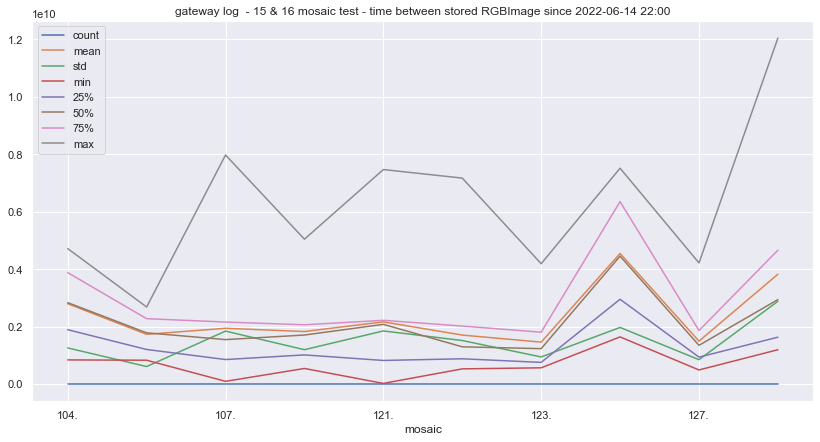

In [24]:
sns.set(style="darkgrid")
ax = stored_RGBImage.groupby(['mosaic'])['time_diff'].describe()
ax.plot(figsize=(14,7), title = 'gateway log  - 15 & 16 mosaic test - time between stored RGBImage since 2022-06-14 22:00');

### 5. time between image stored

In [25]:
stored_image = stored[(stored['7'] == 'image')]
stored_image.head(3)

,datetime,7,mosaic
1404112,2022-06-15 00:00:03.059,image,130.
1404113,2022-06-15 00:00:04.072,image,129.
1404143,2022-06-15 00:00:06.555,image,120.


In [26]:
stored_image.count()

datetime    552436
7           552436
mosaic      552436
dtype: int64

In [27]:
stored_image.mosaic.value_counts(ascending = False)

121.    36700
126.    36552
107.    36510
104.    36509
127.    36501
131.    36492
130.    36464
106.    36436
128.    36310
132.    36154
122.    36128
123.    36065
129.    36027
124.    35985
120.    34468
125.     7941
133.     1194
Name: mosaic, dtype: int64

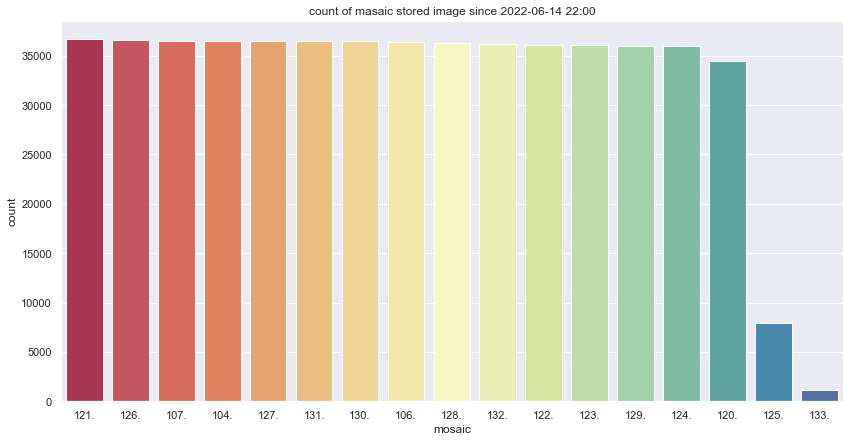

In [28]:
sns.set(style="darkgrid")
plt.figure(figsize=(14,7))
plt.title ('count of masaic stored image since 2022-06-14 22:00')

sns.countplot(x='mosaic', data=stored_image , palette='Spectral', order = stored_image.mosaic.value_counts().index);

In [29]:
# time betweend stored images

stored_image['time_diff'] = stored_image['datetime'].diff()
stored_image.describe()

,time_diff
count,552435
mean,0 days 00:00:02.188447889
std,0 days 00:00:02.923255709
min,0 days 00:00:00
25%,0 days 00:00:01.194000
50%,0 days 00:00:01.468000
75%,0 days 00:00:02.126000
max,0 days 00:06:01.983000


In [30]:
# sorting out of errors - check 3 min same count 552425 as for 1 min 30 
gruped_image = stored_image[stored_image['time_diff'] < '0 days 00:3:30.000']
gruped_image.describe()

,time_diff
count,552432
mean,0 days 00:00:02.186771705
std,0 days 00:00:02.828557913
min,0 days 00:00:00
25%,0 days 00:00:01.194000
50%,0 days 00:00:01.468000
75%,0 days 00:00:02.126000
max,0 days 00:01:47.693000


In [31]:
# sorting out of errors - check 1 min 20 sec count geting lower 552425, mosaics needs 1 min 30 to comeback
gruped_image = stored_image[stored_image['time_diff'] < '0 days 00:01:20.000']
gruped_image.describe()

,time_diff
count,552413
mean,0 days 00:00:02.183737267
std,0 days 00:00:02.780483508
min,0 days 00:00:00
25%,0 days 00:00:01.194000
50%,0 days 00:00:01.468000
75%,0 days 00:00:02.126000
max,0 days 00:01:19.005000


In [32]:
gruped_image = stored_image[stored_image['time_diff'] < '0 days 00:00:03.000']
gruped_image.describe()

,time_diff
count,476900
mean,0 days 00:00:01.497177726
std,0 days 00:00:00.627662061
min,0 days 00:00:00
25%,0 days 00:00:00.828000
50%,0 days 00:00:01.420000
75%,0 days 00:00:02.079000
max,0 days 00:00:02.999000


In [33]:
# sorting out of errors - 1 min 30 sec  = count	552425
gruped_image = stored_image[stored_image['time_diff'] < '0 days 00:1:30.000']
gruped_image.describe()

,time_diff
count,552425
mean,0 days 00:00:02.185538664
std,0 days 00:00:02.807230602
min,0 days 00:00:00
25%,0 days 00:00:01.194000
50%,0 days 00:00:01.468000
75%,0 days 00:00:02.126000
max,0 days 00:01:29.149000


In [34]:
gruped_image['time_diff_sec'] = gruped_image.apply(lambda row: row['time_diff'].total_seconds()  , axis = 1)
gruped_image.groupby(['mosaic'])['time_diff_sec'].describe()

,count,mean,std,min,25%,50%,75%,max
mosaic,,,,,,,,
104.,36509.0,2.199600,2.740439,0.001,1.22200,1.5400,2.131,84.693
106.,36435.0,2.127517,2.338578,0.001,1.20300,1.4850,2.126,88.635
107.,36509.0,2.093961,2.170104,0.001,1.20300,1.4780,2.120,71.509
120.,34468.0,2.085927,2.095945,0.001,1.21600,1.4620,2.125,49.419
121.,36700.0,3.334961,6.114400,0.001,1.36400,1.7230,2.202,86.967
122.,36126.0,2.116856,2.336005,0.001,1.19600,1.4530,2.118,80.339
123.,36065.0,2.155175,2.495838,0.001,1.21200,1.5070,2.128,68.361
124.,35985.0,2.099270,2.446777,0.001,1.19200,1.4680,2.127,89.137
125.,7941.0,1.302399,2.368497,0.000,0.00100,0.7700,1.665,35.082


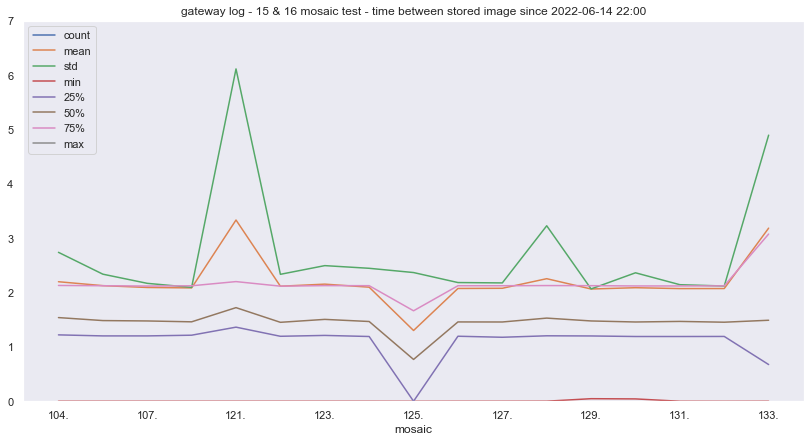

In [35]:
sns.set(style="dark")
ax = gruped_image.groupby(['mosaic'])['time_diff_sec'].describe()

ax.plot(figsize=(14,7), ylim = (0, 7) ,title = 'gateway log - 15 & 16 mosaic test - time between stored image since 2022-06-14 22:00');

### 6. Gateway CPU temp

# wnioski gateway & mosaic cpu temp

ilość pomiarów dla mosaic i gateway była równa w badanym czasie

gateway temp, przyjmował wartości:    
count	183862, temp - od	48.9  przez mediana	61.2  do do	69.3


mosaic temp, przyjmował wartości:

count	183862, temp - od	25.0, przez mediana 29.9 do 35.8

In [36]:
gateway_cpu_temp = gateway[(gateway['7'] == 'cpu')]
gateway_cpu_temp["mosaic"] = pd.to_numeric(gateway_cpu_temp["mosaic"])
gateway_cpu_temp = gateway_cpu_temp[['datetime', 'stored', '7', '8', 'mosaic']]
gateway_cpu_temp. rename(columns = {'mosaic':'temp'}, inplace = True)

gateway_cpu_temp.head(3)

,datetime,stored,7,8,temp
1404097,2022-06-15 00:00:00.826,Gateway,cpu,temp:,59.1
1404334,2022-06-15 00:00:29.431,Gateway,cpu,temp:,60.1
1404360,2022-06-15 00:00:33.465,Gateway,cpu,temp:,60.1


In [37]:
gateway_cpu_temp.describe()

,temp
count,183862.000000
mean,61.176639
std,2.046993
min,48.900000
25%,60.700000
50%,61.200000
75%,61.800000
max,69.300000


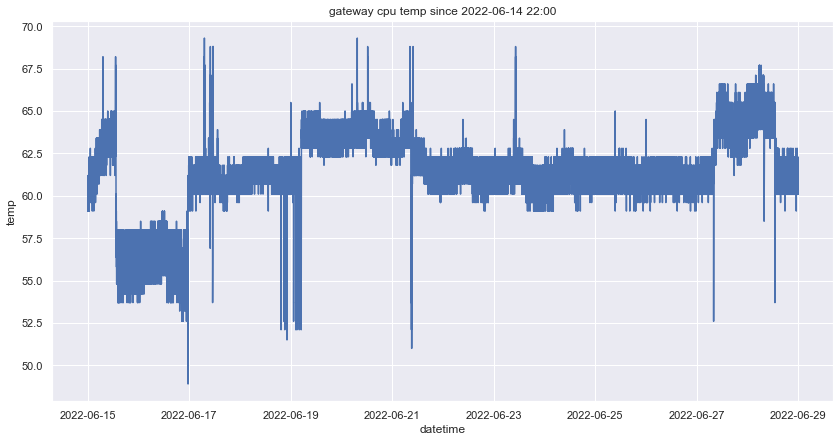

In [38]:
sns.set(style="darkgrid")
plt.figure(figsize=(14,7))
sns.lineplot(data = gateway_cpu_temp, x = 'datetime', y = 'temp')
plt.title("gateway cpu temp since 2022-06-14 22:00");

### 7 Mosaic CPU temp

In [39]:
mosaic_cpu_temp = gateway[(gateway['8'] == 'cpu')]
mosaic_cpu_temp["10"] = pd.to_numeric(mosaic_cpu_temp["10"])
mosaic_cpu_temp = mosaic_cpu_temp[['datetime', 'stored', '7', '8', 'mosaic', '10']]
mosaic_cpu_temp. rename(columns = {'10':'temp'}, inplace = True)

mosaic_cpu_temp.head(3)

,datetime,stored,7,8,mosaic,temp
1404096,2022-06-15 00:00:00.799,Mosaic,120,cpu,temp:,31.5
1404333,2022-06-15 00:00:29.404,Mosaic,107,cpu,temp:,31.5
1404359,2022-06-15 00:00:33.435,Mosaic,127,cpu,temp:,30.4


In [40]:
mosaic_cpu_temp.describe()

,temp
count,183862.000000
mean,29.732987
std,1.097561
min,25.000000
25%,29.300000
50%,29.900000
75%,30.400000
max,35.800000


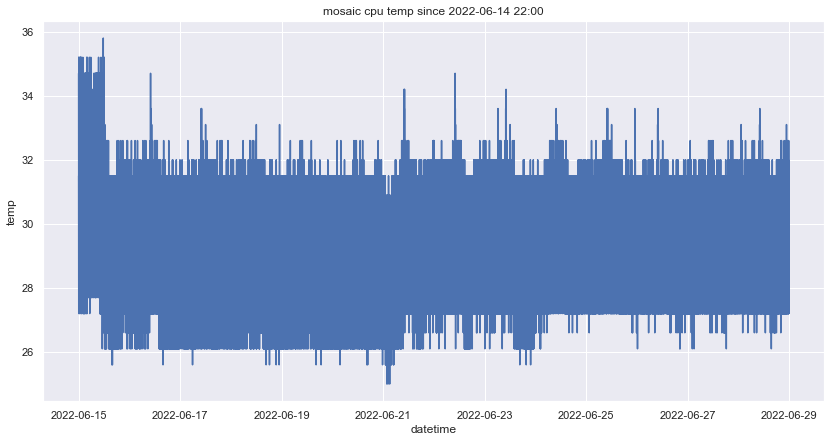

In [41]:
sns.set(style="darkgrid")
plt.figure(figsize=(14,7))
sns.lineplot(data = mosaic_cpu_temp, x = 'datetime', y = 'temp')
plt.title("mosaic cpu temp since 2022-06-14 22:00");

# info server

# wnioski info server
w logach o typu "info_server", pojawiły się wpisy typu :

on_images:, on_device_data:, on_rgb_image:,  on_disconnect:, on_connect:      

on_disconnect oraz on_connect - nie były wpisami datowanymi 
    
1. on_device_data:    277533 razy 
    
wpisy niosły info: on_device_data:	Requested	device data mosaic no. 

czas pomiedzy requestami device dla danej mozaiki był bardzo szybki mniej niż pół sekundy, 

został zobrazowany na describie dla dnaej mozaiki  

2. on_rgb_image:      125859

ten wpis dzielił się na dwie grupy, definiujące czy zostało przesłane czy nie  

on_rgb_image:	Requested	device	128

on_rgb_image:	No	RGB	image	for	device	124
        
    czasy przesyłów udanych, czy różnica pomiędzy nimi dla danej mozaiki była bardzo szybka do pół sekundy,
    co zostało zobrazowane na describach i grafach 
    
    przesyły nie udane w czasie zostały zobrazowane na grafie, oraz występowania braku przesyłów dla danej mozaiki 

3. on_images 360851 razy

  log niósł info : on_images:	Requested	images:	{},
  
  różnica w czasie do 13 sec, przeważnie mniej niż pół sekundy

In [42]:
info_server = gateway[(gateway['3'] == 'server')]
info_server_counts = info_server['5'].value_counts()
info_server_counts

on_images:         360851
on_device_data:    277533
on_rgb_image:      125859
on_disconnect:         71
on_connect:            71
Name: 5, dtype: int64

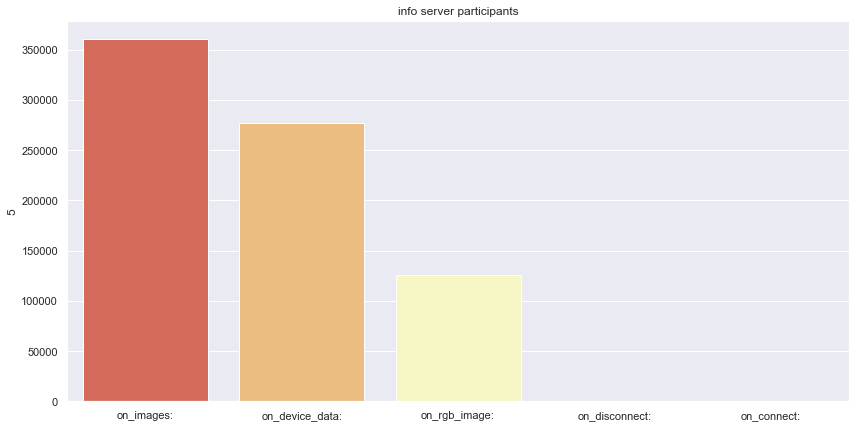

In [43]:
plt.figure(figsize=(14,7))
plt.title ('info server participants')
sns.barplot(x= info_server_counts.index, y= info_server_counts , palette='Spectral');

## 8. info server Requested on device 

In [44]:
info_server1 = info_server[(info_server['5'] == 'on_device_data:')]
info_server1 = info_server1[['datetime', '5', 'stored', '7', '8']]
info_server1. rename(columns = {'8':'mosaic'}, inplace = True)
info_server1.head(3)

,datetime,5,stored,7,mosaic
1404577,2022-06-15 00:00:54.784,on_device_data:,Requested,device,128
1404578,2022-06-15 00:00:54.795,on_device_data:,Requested,device,124
1404579,2022-06-15 00:00:54.805,on_device_data:,Requested,device,104


In [45]:
info_server1['time_diff'] = info_server1['datetime'].diff()
info_server1 = info_server1[(info_server1['time_diff'] >= '0 days')]
info_server1.describe()

,time_diff
count,277532
mean,0 days 00:00:04.355976301
std,0 days 00:03:40.466274618
min,0 days 00:00:00.002000
25%,0 days 00:00:00.009000
50%,0 days 00:00:00.010000
75%,0 days 00:00:00.012000
max,1 days 08:11:18.873000


In [46]:
info_server1 = info_server1[(info_server1['time_diff'] < '0 days 00:00:01.000000')]
info_server1.describe()

,time_diff
count,259221
mean,0 days 00:00:00.010989487
std,0 days 00:00:00.006573
min,0 days 00:00:00.002000
25%,0 days 00:00:00.009000
50%,0 days 00:00:00.010000
75%,0 days 00:00:00.011000
max,0 days 00:00:00.998000


In [47]:
info_server1.groupby(['mosaic'])['time_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
mosaic,,,,,,,,
104,18049,0 days 00:00:00.012320460,0 days 00:00:00.008428623,0 days 00:00:00.003000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.013000,0 days 00:00:00.562000
106,18051,0 days 00:00:00.011117832,0 days 00:00:00.005852226,0 days 00:00:00.003000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.011000,0 days 00:00:00.121000
107,18113,0 days 00:00:00.011224203,0 days 00:00:00.005986561,0 days 00:00:00.002000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.011000,0 days 00:00:00.131000
120,18114,0 days 00:00:00.010601965,0 days 00:00:00.005524168,0 days 00:00:00.002000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.011000,0 days 00:00:00.130000
121,18114,0 days 00:00:00.010569007,0 days 00:00:00.005122451,0 days 00:00:00.002000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.011000,0 days 00:00:00.113000
122,18114,0 days 00:00:00.010739648,0 days 00:00:00.005683562,0 days 00:00:00.002000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.011000,0 days 00:00:00.151000
123,18114,0 days 00:00:00.010587666,0 days 00:00:00.005131373,0 days 00:00:00.002000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.011000,0 days 00:00:00.155000
124,18048,0 days 00:00:00.010972351,0 days 00:00:00.011930751,0 days 00:00:00.003000,0 days 00:00:00.008000,0 days 00:00:00.009000,0 days 00:00:00.011000,0 days 00:00:00.998000
125,4098,0 days 00:00:00.011226939,0 days 00:00:00.005782168,0 days 00:00:00.005000,0 days 00:00:00.009000,0 days 00:00:00.010000,0 days 00:00:00.011000,0 days 00:00:00.106000


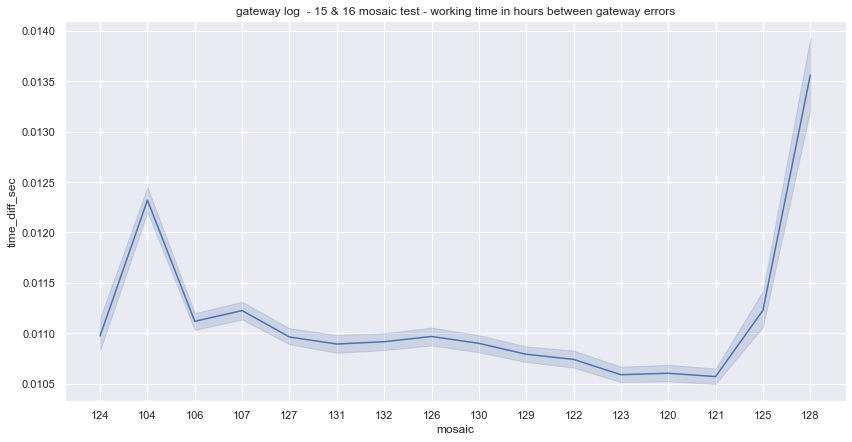

In [48]:
info_server1['time_diff_sec'] = info_server1.apply(lambda row: row['time_diff'].total_seconds() , axis = 1)
info_server1. rename(columns = {'8':'mosaic'}, inplace = True)
plt.figure(figsize=(14,7))
plt.title('gateway log  - 15 & 16 mosaic test - working time in hours between gateway errors')
sns.lineplot(data = info_server1, x  = 'mosaic', y = 'time_diff_sec');

### 9 info server on rgb image Requested

In [49]:
info_server2_requested = info_server[(info_server['5'] == 'on_rgb_image:') & 
                                     (info_server['stored'] == 'Requested')]
info_server2_requested = info_server2_requested[['datetime', '5', 'stored', '7', '8']]

info_server2_requested.head(3)

,datetime,5,stored,7,8
1404553,2022-06-15 00:00:54.708,on_rgb_image:,Requested,device,128
1404554,2022-06-15 00:00:54.713,on_rgb_image:,Requested,device,124
1404556,2022-06-15 00:00:54.728,on_rgb_image:,Requested,device,104


In [50]:
info_server2_requested['time_diff'] = info_server2_requested['datetime'].diff()
info_server2_requested = info_server2_requested[(info_server2_requested['time_diff'] >= '0 days')]
info_server2_requested.describe()

,time_diff
count,92327
mean,0 days 00:00:13.092621150
std,0 days 00:06:27.242340234
min,0 days 00:00:00.001000
25%,0 days 00:00:00.004000
50%,0 days 00:00:00.005000
75%,0 days 00:00:00.007000
max,1 days 08:28:02.551000


In [51]:
rbg_requested = info_server2_requested[(info_server2_requested['time_diff'] < '0 days 00:00:02.000000')]
rbg_requested.describe()

,time_diff
count,86302
mean,0 days 00:00:00.005873954
std,0 days 00:00:00.005082753
min,0 days 00:00:00.001000
25%,0 days 00:00:00.004000
50%,0 days 00:00:00.005000
75%,0 days 00:00:00.006000
max,0 days 00:00:00.150000


In [52]:
rbg_requested

,datetime,5,stored,7,8,time_diff
1404554,2022-06-15 00:00:54.713,on_rgb_image:,Requested,device,124,0 days 00:00:00.005000
1404556,2022-06-15 00:00:54.728,on_rgb_image:,Requested,device,104,0 days 00:00:00.015000
1404558,2022-06-15 00:00:54.732,on_rgb_image:,Requested,device,106,0 days 00:00:00.004000
1404560,2022-06-15 00:00:54.736,on_rgb_image:,Requested,device,107,0 days 00:00:00.004000
1404562,2022-06-15 00:00:54.741,on_rgb_image:,Requested,device,127,0 days 00:00:00.005000
...,...,...,...,...,...,...
4482303,2022-06-28 23:47:37.124,on_rgb_image:,Requested,device,122,0 days 00:00:00.003000
4482304,2022-06-28 23:47:37.128,on_rgb_image:,Requested,device,123,0 days 00:00:00.004000
4482305,2022-06-28 23:47:37.132,on_rgb_image:,Requested,device,120,0 days 00:00:00.004000
4482306,2022-06-28 23:47:37.136,on_rgb_image:,Requested,device,121,0 days 00:00:00.004000


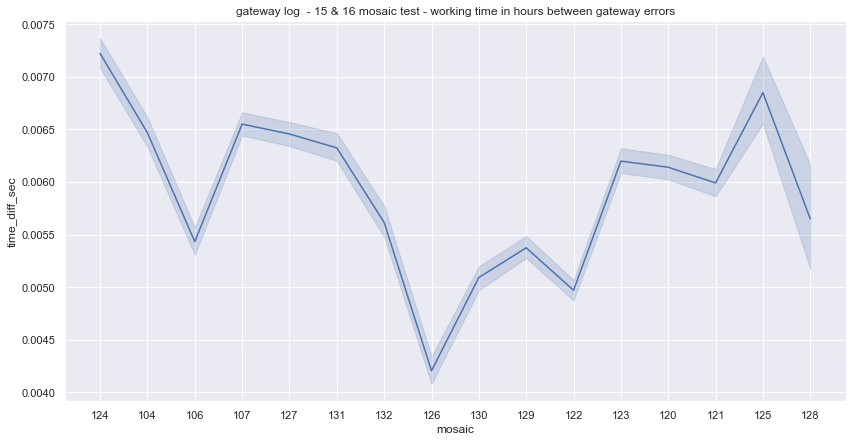

In [53]:
rbg_requested['time_diff_sec'] = rbg_requested.apply(lambda row: row['time_diff'].total_seconds() , axis = 1)
plt.figure(figsize=(14,7))
plt.title('gateway log  - 15 & 16 mosaic test - working time in hours between gateway errors')
rbg_requested.rename(columns = {'8':'mosaic'}, inplace = True)
sns.lineplot(data = rbg_requested, y  = 'time_diff_sec', x = 'mosaic');

### 10 info server no RBG data is ready

In [54]:
info_server2_no_image = info_server[(info_server['5'] == 'on_rgb_image:') & 
                                     (info_server['stored'] == 'No')]
info_server2_no_image = info_server2_no_image[['datetime', '5', 'stored', '7', '8', '10', '11', '12']]
info_server2_no_image. rename(columns = {'12':'mosaic'}, inplace = True)
info_server2_no_image.head(3)

,datetime,5,stored,7,8,10,11,mosaic
1404555,2022-06-15 00:00:54.713,on_rgb_image:,No,RGB,image,for,device,124
1404557,2022-06-15 00:00:54.729,on_rgb_image:,No,RGB,image,for,device,104
1404559,2022-06-15 00:00:54.733,on_rgb_image:,No,RGB,image,for,device,106


In [55]:
info_server2_count = info_server2_no_image['mosaic'].value_counts()
info_server2_count

124    6026
131    6026
130    6026
132    6026
121    3932
125    1364
107    1297
120    1043
133     574
106     290
123     285
104     270
127     266
126      72
128      20
129       7
122       7
Name: mosaic, dtype: int64

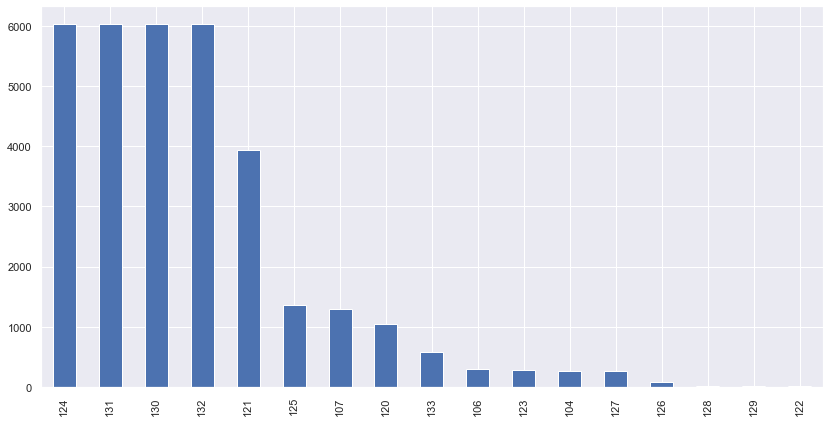

In [56]:
info_server2_count.plot(kind ='bar', figsize=(14,7));

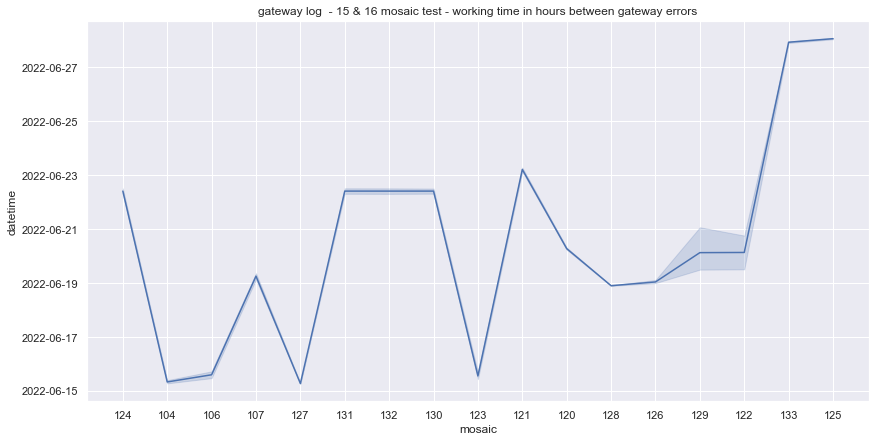

In [57]:
plt.figure(figsize=(14,7))
plt.title('gateway log  - 15 & 16 mosaic test - working time in hours between gateway errors')
sns.lineplot(data = info_server2_no_image, y  = 'datetime', x = 'mosaic');

### 11 info server on images

In [58]:
info_server3 = info_server[(info_server['5'] == 'on_images:')]
info_server3 = info_server3[['datetime', '5', 'stored', '7', '8']]
info_server3['time_diff'] = info_server3['datetime'].diff()
info_server3 = info_server3.iloc[1:]
info_server3.head(3)

,datetime,5,stored,7,8,time_diff
1404123,2022-06-15 00:00:05.060,on_images:,Requested,images:,{},0 days 00:00:03.001000
1404153,2022-06-15 00:00:08.059,on_images:,Requested,images:,{},0 days 00:00:02.999000
1404183,2022-06-15 00:00:11.059,on_images:,Requested,images:,{},0 days 00:00:03


In [59]:
info_server3.describe()

,time_diff
count,360850
mean,0 days 00:00:03.350351766
std,0 days 00:03:24.398736268
min,0 days 00:00:00.090000
25%,0 days 00:00:02.999000
50%,0 days 00:00:03
75%,0 days 00:00:03.001000
max,1 days 10:06:23.806000


In [60]:
info_on_image = info_server3[(info_server3['time_diff'] < '0 days 00:00:15.000000')]
info_on_image.describe()

,time_diff
count,360825
mean,0 days 00:00:03.000053108
std,0 days 00:00:00.030473120
min,0 days 00:00:00.090000
25%,0 days 00:00:02.999000
50%,0 days 00:00:03
75%,0 days 00:00:03.001000
max,0 days 00:00:13.615000


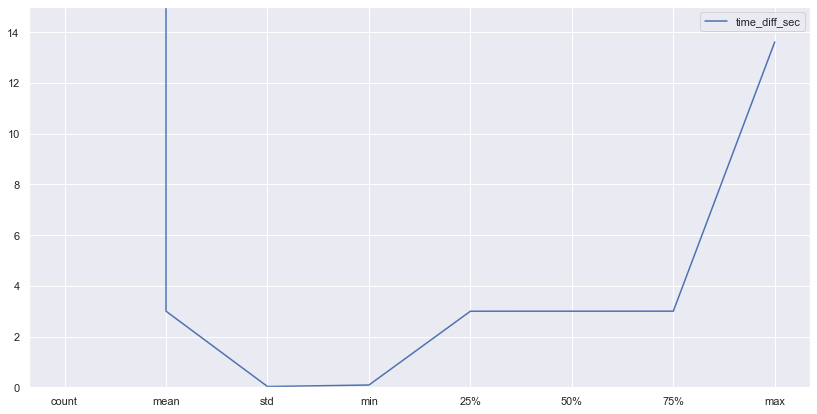

In [61]:
info_on_image['time_diff_sec'] = info_on_image.apply(lambda row: row['time_diff'].total_seconds() , axis = 1)
info_on_image.describe().plot(ylim=(0, 15), figsize=(14,7));

# wnioski calibration log

dla calibration loga, została zobrazowana najdłużej 

działająca konfiguracja weekendu 18 - 21 oraz dominanta erroru przypadającego na konkretną mozajke

# calibration.log parse from 2022-06-14 22:12:19.000 to 2022-06-21

In [62]:
calibration = pd.read_csv( 'calibration.log',header=None ,on_bad_lines='skip')
calibration = calibration[0]
calibration = calibration.str.split(' ', expand=True)
calibration.columns = ["date", "time", "info", "3",  "4",  "log_check", "mosaic_info" , "info_delay" , "mosaic" ,
                       "9", "delay", "11" ,"12", "mosaic_time", "14"]
calibration['datetime'] = calibration["date"] + " " + calibration['time']
calibration['datetime'] = pd.to_datetime(calibration['datetime'])
calibration = calibration[(calibration['datetime'] > '2022-06-14 22:12:19.000')]

calibration.head()

,date,time,info,3,4,log_check,mosaic_info,info_delay,mosaic,9,delay,11,12,mosaic_time,14,datetime
60710,2022-06-15,13:22:41.684,INFO,delay_calibration,-,<module>:,New,test,start.,None,None,None,None,None,None,2022-06-15 13:22:41.684
60711,2022-06-17,07:29:19.988,INFO,delay_calibration,-,<module>:,New,test,start.,None,None,None,None,None,None,2022-06-17 07:29:19.988
60712,2022-06-18,19:22:51.192,INFO,delay_calibration,-,log_correct_check:,Mosaic,no.,120,is,not,responding,for,126.395,seconds,2022-06-18 19:22:51.192
60713,2022-06-18,19:22:51.286,INFO,delay_calibration,-,<module>:,Counter,reduced,to,14,None,None,None,None,None,2022-06-18 19:22:51.286
60714,2022-06-18,19:22:51.296,INFO,delay_calibration,-,<module>:,Request,delay,increased,to,1.1,None,None,None,None,2022-06-18 19:22:51.296


### delay

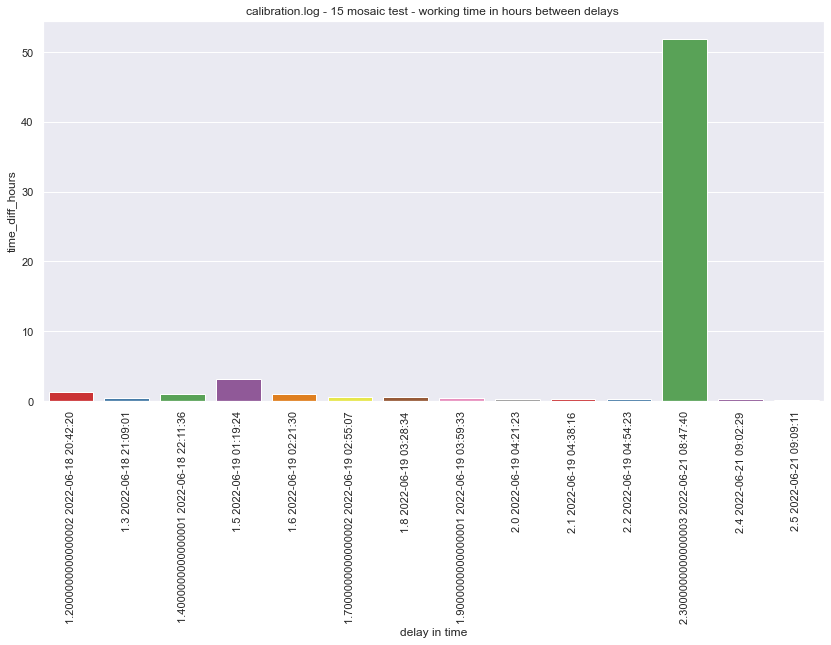

In [63]:
delay = calibration[(calibration['info_delay'] == 'delay')]
delay = delay[['datetime', 'delay']]
delay['time_diff_hours'] = delay['datetime'].diff()
delay['time_diff_hours'] = delay.apply(lambda row: row['time_diff_hours'].total_seconds() / 3600, axis = 1)
delay = delay.iloc[1:]
delay["new"] = delay["datetime"].astype(str)
delay[['time', 'drop']] = delay['new'].str.split('.', n=1, expand=True)
delay["delay"] = delay["delay"].astype(str)
delay["delay in time"] = delay['delay'] + " " + delay['time']
plt.figure(figsize=(14,7))
plt.title ('calibration.log - 15 mosaic test - working time in hours between delays ')
sns.barplot(x='delay in time', y= 'time_diff_hours', data = delay , palette='Set1')
plt.xticks(rotation=90);

### calibration mosaic_not responding 

In [64]:
mosaic_not_resp = calibration[(calibration['mosaic_info'] == 'Mosaic')]
mosaic_not_resp = mosaic_not_resp[['datetime', 'mosaic', 'mosaic_time' ]]
mosaic_not_resp['time_diff_hours'] = mosaic_not_resp['datetime'].diff()
mosaic_not_resp['time_diff_hours'] = mosaic_not_resp.apply(lambda row: row['time_diff_hours'].total_seconds() / 3600, axis = 1)
mosaic_not_resp = mosaic_not_resp.iloc[1:]
mosaic_not_resp["new"] = mosaic_not_resp["datetime"].astype(str)
mosaic_not_resp[['time', 'drop']] = mosaic_not_resp['new'].str.split('.', n=1, expand=True)
mosaic_not_resp["mosaic in time"] = mosaic_not_resp['mosaic'] + " " + mosaic_not_resp['time']
mosaic_not_resp

,datetime,mosaic,mosaic_time,time_diff_hours,new,time,drop,mosaic in time
60717,2022-06-18 20:42:20.340,104,121.132,1.324763,2022-06-18 20:42:20.340,2022-06-18 20:42:20,340,104 2022-06-18 20:42:20
60722,2022-06-18 21:09:01.184,128,120.968,0.444679,2022-06-18 21:09:01.184,2022-06-18 21:09:01,184,128 2022-06-18 21:09:01
60727,2022-06-18 22:11:36.909,107,121.885,1.043257,2022-06-18 22:11:36.909,2022-06-18 22:11:36,909,107 2022-06-18 22:11:36
60732,2022-06-19 01:19:24.403,122,120.406,3.129859,2022-06-19 01:19:24.403,2022-06-19 01:19:24,403,122 2022-06-19 01:19:24
60737,2022-06-19 02:21:30.669,128,120.37,1.035074,2022-06-19 02:21:30.669,2022-06-19 02:21:30,669,128 2022-06-19 02:21:30
60742,2022-06-19 02:55:07.431,107,122.289,0.560212,2022-06-19 02:55:07.431,2022-06-19 02:55:07,431,107 2022-06-19 02:55:07
60747,2022-06-19 03:28:34.982,131,121.24,0.557653,2022-06-19 03:28:34.982,2022-06-19 03:28:34,982,131 2022-06-19 03:28:34
60752,2022-06-19 03:59:33.400,104,120.179,0.516227,2022-06-19 03:59:33.400,2022-06-19 03:59:33,400,104 2022-06-19 03:59:33
60757,2022-06-19 04:21:23.870,128,120.167,0.364019,2022-06-19 04:21:23.870,2022-06-19 04:21:23,870,128 2022-06-19 04:21:23
60762,2022-06-19 04:38:16.916,128,120.164,0.281402,2022-06-19 04:38:16.916,2022-06-19 04:38:16,916,128 2022-06-19 04:38:16


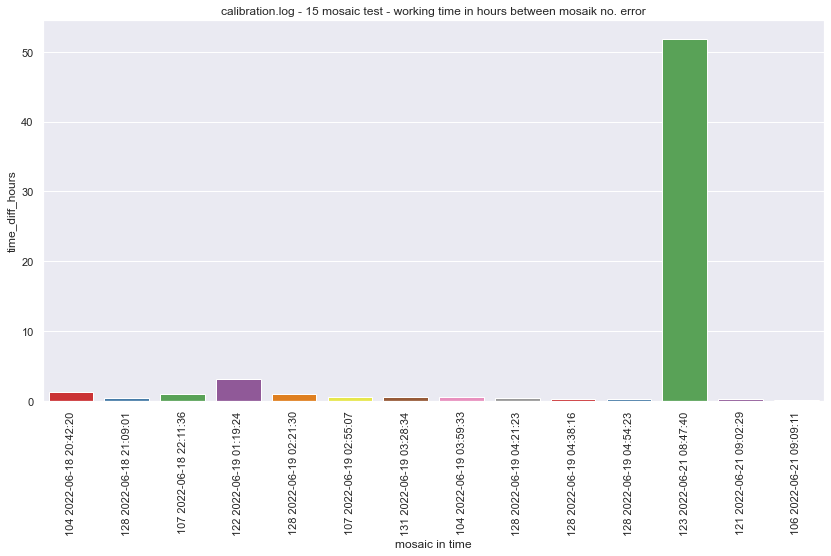

In [65]:
plt.figure(figsize=(14,7))
plt.title ('calibration.log - 15 mosaic test - working time in hours between mosaik no. error')
sns.barplot(x="mosaic in time", y= 'time_diff_hours', data = mosaic_not_resp , palette='Set1')
plt.xticks(rotation=90);

In [66]:
mosaic_not_resp.mosaic.value_counts(sort = "ascending")

128    5
104    2
107    2
122    1
131    1
123    1
121    1
106    1
Name: mosaic, dtype: int64

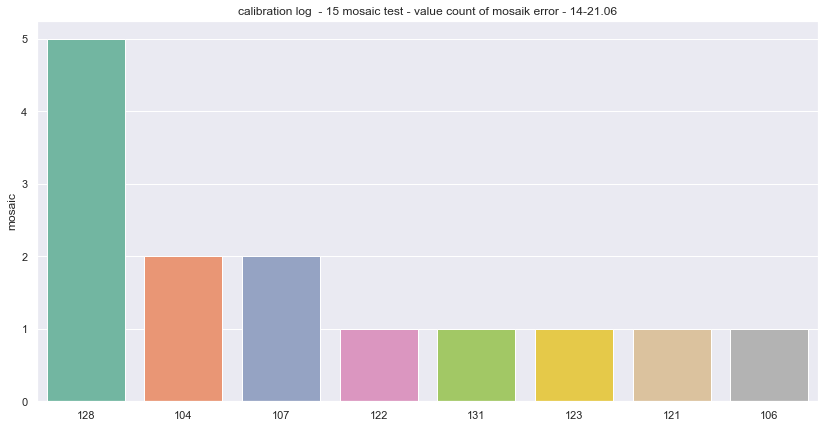

In [67]:
dominant_mosaic_crush = mosaic_not_resp.mosaic.value_counts(sort = "ascending")
plt.figure(figsize=(14,7))
plt.title('calibration log  - 15 mosaic test - value count of mosaik error - 14-21.06')
sns.barplot(x=dominant_mosaic_crush.index, y= dominant_mosaic_crush, palette='Set2');